<a href="https://colab.research.google.com/github/tozanni/COVID19_MEX_MASTER/blob/master/COVID_Ajuste_de_R0_con_SSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ajuste de parámetros del modelo SEIR

---



Eduardo H. Ramirez (eduardo@ensitech.com)

Basado en la implementación de SEIR de de Miguel Núñez publicada en:

https://github.com/NunezKant/COVID-19_GDL/blob/master/Desarrollo_de_COVID_19_en_Guadalajara_Miguel_N%C3%BA%C3%B1ez.ipynb


In [0]:
%matplotlib inline
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import pymc3 as pm
#import altair as alt
#import plotly.express as px
#import requests
#import io

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

In [0]:
def SEIR(IC, pmtrs,t,theta=1):
  """
  Esta parte de código es la que implementa las ecuaciones diferenciales.

  Se resuelven por medio de integración númerica de Euler
  """
  
  So,Eo,Io,Ro,Pop = IC
  S,E,I,R = [So],[Eo],[Io],[Ro]
  alpha,beta,gamma = pmtrs
  dt = t[1]-t[0]
  for _ in t[1:]:
    St = S[-1] - (theta*beta*S[-1]*I[-1])*dt
    Et = E[-1] + (theta*beta*S[-1]*I[-1] - alpha*E[-1])*dt
    It = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
    Rt = R[-1] + (gamma*I[-1])*dt
    S.append(St)
    E.append(Et)
    I.append(It)
    R.append(Rt)
  return S,E,I,R

def SEIR_I(ic, params):
  """
  Esta funcion sirve para generar una serie de la clase infectados
  de todo el periodo. Es util para poder aplicarle funciones como SSE 
  en otros analisis.
  """

  dias_evaluacion = 90 #asumimos 90 días
  dt = 1
  periodo_evaluacion = np.linspace(0, dias_evaluacion, dias_evaluacion + 1)
  So,Eo,Io,Ro,Pop = ic

  S,E,I,R = SEIR(ic,params,periodo_evaluacion)
  E_a = np.array(E)*Pop
  I_a = np.array(I)*Pop

  Clase = np.array(["Expuestos"]*np.array(E).shape[0] + ["Infectados"]*np.array(E).shape[0])
  Dias = np.concatenate([np.arange(0,91,1),np.arange(0,91,1)])

  SEIR_df = pd.DataFrame({
      "Casos": np.concatenate([E_a,I_a]),
      "Clase": Clase,
      "Dias" : Dias
  })

  SEIR_df.reset_index(inplace=True)
  SEIR_df.set_index("Dias", inplace=True)

  ## Devolver solo una serie (Infectados)
  return SEIR_df[["Casos"]][SEIR_df['Clase'] == 'Infectados']


El dia 0 es hoy 22/03/2020, si se quiere correr el análisis después habrá que cambiar las condiciones inciales (actualizar en número de infectados reportados)

In [0]:
alpha = 0.2
beta = 1.75
gamma = 0.5
parametros = alpha, beta, gamma

#Condiciones iniciales

Pop = 4225000  # ZMM
I_o = 32 / Pop  # Tenemos 32 casos
E_o = (32*4)/ Pop # Asumimos 4 expuestos por caso
S_o = (1) - (E_o+I_o) # El resto somos suceptibles
R_o = 0 # NO hay ningun recuperado

IC = S_o,E_o,I_o,R_o,Pop

## Corrida baseline (solo basada en condiciones iniciales)
x = SEIR_I(IC, parametros)
#x

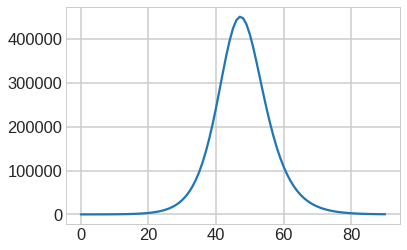

In [0]:
plt.plot(x)

### Fit de $\beta$ y $R_{0}$ mediante mínimos cuadrados

In [0]:
## Datos reales del estado bajo analisis
## OJO: Variable global usada en SSE

#22 de Marzo: 32
#23 de Marzo: 48
#24 de Marzo: 52
#25 de Marzo: 57
#26 de Marzo: 60

observaciones = {"I":[ 32, 48, 52, 57, 60 ]}
obs_df = pd.DataFrame.from_dict(observaciones)

In [0]:
def SSE(ic, params, data):
  x = SEIR_I(ic, params)
  err_sq = (x.head(data["I"].count())["Casos"] - data["I"])**2
  return sum(err_sq)

## Calculo inicial de SSE
SSE(IC, parametros, obs_df)

670.4817730727385

In [0]:
## Factor de transmisión, lo variamos de 0.25 a 5
alpha, beta, gamma = parametros
betas = np.linspace(0.25,5,200)

## Stackear en arreglo de (200x3) donde solo varia beta
alphas = np.full((1,200),alpha)
gammas = np.full((1,200),gamma)

#Arreglo de 200 variaciones de parámetros
params = np.vstack([alphas[0], betas, gammas[0]]).transpose()
#params

In [0]:
y_sse = [SSE(IC, list(params_i), obs_df) for params_i in params]

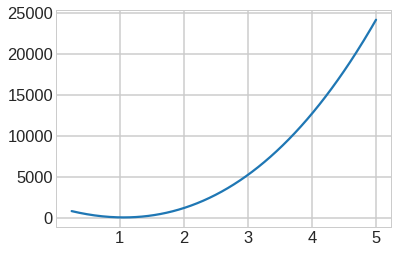

In [0]:
## Curva de mínimos errores al cuadrado (SSE)
plt.plot(betas, y_sse)

In [0]:
## El valor minimo de SSE
np.min(y_sse)

66.00957057386465

In [0]:
## Los parametros que minimizan SSE
min_params = params[np.argmin(y_sse)]
min_params

array([0.2       , 1.06155779, 0.5       ])

In [0]:
## Estimación puntual de R0
## Asumiendo gamma fija (0.5)
R0 = min_params[1] / min_params[2]
R0

2.1231155778894473

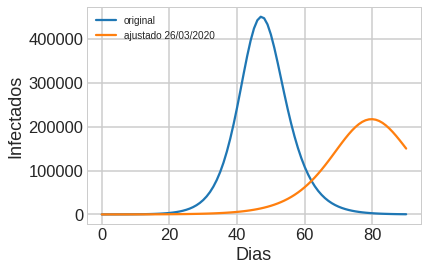

In [0]:
## Calcular una nueva curva ajustada con los parámetros que minimizan SSE

x_adj = SEIR_I(IC,min_params )
plt.plot(x, label="original")
plt.plot(x_adj, label="ajustado 26/03/2020")
plt.xlabel("Dias")
plt.ylabel("Infectados")
plt.legend(loc=2, fontsize=10)



TODOS: 
- Análisis de residuales de mínimos cuadrados
- Fit multiparametro (con este metodo o con otros)
- Ajuste de distribuciones con PyMC3
